In [1]:
using ComponentArrays
using Distributions
using GLMakie
using Lux
using LuxCUDA
using OptimizationOptimJL
using Random
using UnPack
using Zygote
using CairoMakie  # Backend que funciona en notebooks
using Flux
using StatsBase



Current loss: 0.6974821730170347
Current loss: 0.5175397339572827
Current loss: 0.2600696692144542
Current loss: 0.11345628284405537
Current loss: 0.07723845659932932
Current loss: 0.04363271842335357
Current loss: 0.025331626403804017
Current loss: 0.013028775093364493
Current loss: 0.011285634058651765
Current loss: 0.010029259737479873
Current loss: 0.009170678640493736
Current loss: 0.008844694910468017
Current loss: 0.00867885261622146
Current loss: 0.008602045162955372
Current loss: 0.008567425255391949
Current loss: 0.008551799718397493
Current loss: 0.00854649520699475
Current loss: 0.008545233005385625
Current loss: 0.008544605012276125
Current loss: 0.00854443703372558
Current loss: 0.00854439255178381
Current loss: 0.008544376090043835
Current loss: 0.008544365375527264
Current loss: 0.008544351009524631
Current loss: 0.008544308394151752
Current loss: 0.008544050133923412
Current loss: 0.008542461805149662
Current loss: 0.008523865002551216
Current loss: 0.00851704320228234

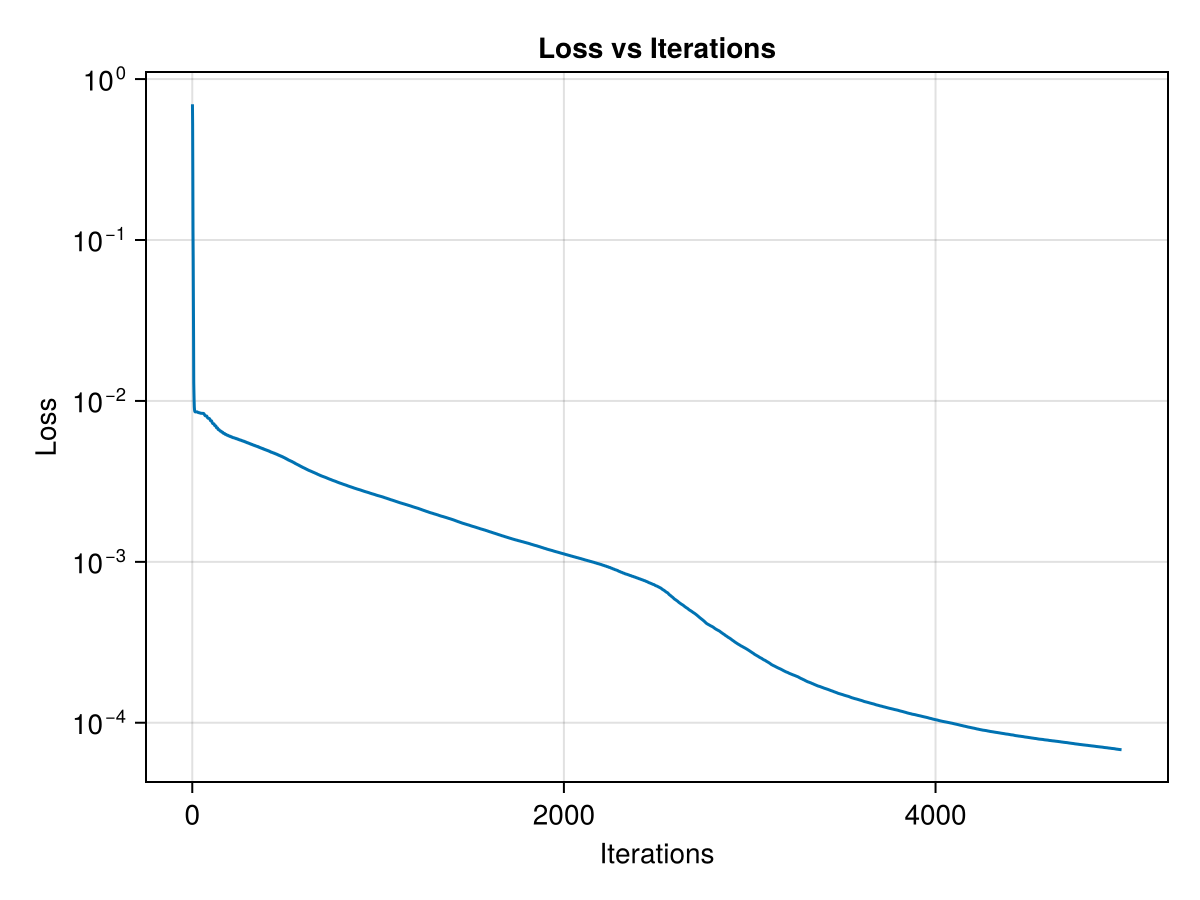

ComponentVector{Float64}(layer_1 = (weight = [0.2045988877386805 -0.03813686377932205 0.2534224254465889 -0.022442122080764; -0.31285623484350705 -0.36201666582173037 -0.18838291247444114 0.34479659089212245; … ; -0.3024932005719827 -0.2983408121401765 0.03221831440634803 -0.2750885119174322; -0.007470422512865715 -0.22481338461714379 0.27151756463077764 0.16368007368376644], bias = [0.5817000485125814, -1.0853234244559458, 1.2321159562792539, 0.8790117428096765, -0.8032995362710675, -0.816576914962829, -1.118159425707825, -0.38845396645486946, -0.8084528809429544, 0.17659799001316578  …  0.7673743776731564, -0.8613744434498187, -0.4903173980014503, -0.49666207097400494, 0.43252330019827295, -0.7332439524800562, 1.312703889292925, 0.5778190652645344, 0.7406056422316979, 2.349126286395991]), layer_2 = (weight = [1.671169203895938 -0.7857664927343758 … 2.65078602416488 -1.4878051090080444; -1.3673556074990476 0.355327082920505 … -0.4322265652885897 -0.3985530335791847; … ; 2.204864790738

In [20]:
# -------------------------------------------------------------
# PINN para la ecuación de ondas en 3+1 (x,y,z,t)
# Lux + Optimization.jl + FD para derivadas
# -------------------------------------------------------------

using Random, Distributions
using Lux, ComponentArrays
using Optimization, OptimizationOptimJL
using CUDA
using UnPack
using GLMakie



# ------------------------------
# Solución analítica esférica
# u(x,y,z,t) = A/r [ e^{-((t - (r-r0)/c)/σ)^2} + e^{-((t + (r-r0)/c)/σ)^2} ]
# ------------------------------
function u_analytic(x, y, z, t, A, σ, c, r0)
    r = sqrt.(x.^2 .+ y.^2 .+ z.^2)
    r_shift = r .- r0
    saliente = @. exp(-((t - r_shift / c) / σ)^2)
    entrante = @. exp(-((t + r_shift / c) / σ)^2)
    return @. (A / r) * (saliente + entrante)
end

# Para evitar división por cero en r=0 si muestreas cerca del origen:
# puedes desplazar r0>0 y/o limitar el dominio para no incluir r≈0.

# ------------------------------
# Red neuronal (MLP)
# ------------------------------
function create_neural_network(config)
    @unpack N_input, N_neurons, N_layers, N_output = config

    rng = Random.default_rng()
    Random.TaskLocalRNG()
    Random.seed!(rng)

    NN = Lux.Chain(
        Lux.Dense(N_input, N_neurons, tanh),
        [Lux.Dense(N_neurons, N_neurons, tanh) for _ in 1:N_layers]...,
        Lux.Dense(N_neurons, N_output)
    )

    Θ, st = Lux.setup(rng, NN)
    Θ = Θ |> ComponentArray |> gpu_device() .|> Float64
    return NN, Θ, st
end

# ------------------------------
# Generación de datos (4D: x,y,z,t)
# ------------------------------
function generate_input_collocation(config)
    @unpack N_points, xmin, xmax, ymin, ymax, zmin, zmax, tmin, tmax = config
    x = rand(Uniform(xmin, xmax), (1, N_points))
    y = rand(Uniform(ymin, ymax), (1, N_points))
    z = rand(Uniform(zmin, zmax), (1, N_points))
    t = rand(Uniform(tmin, tmax), (1, N_points))
    input = vcat(x, y, z, t) |> gpu_device() .|> Float64
    return input
end

# t = 0 (condición inicial)
function generate_input_initial(config)
    @unpack N_points0, xmin, xmax, ymin, ymax, zmin, zmax = config
    x = rand(Uniform(xmin, xmax), (1, N_points0))
    y = rand(Uniform(ymin, ymax), (1, N_points0))
    z = rand(Uniform(zmin, zmax), (1, N_points0))
    t = zeros(Float64, 1, N_points0)
    input = vcat(x, y, z, t) |> gpu_device() .|> Float64
    return input
end

# Contorno espacial (6 caras del cubo) para tiempos en [tmin,tmax]
function generate_input_boundary(config)
    @unpack N_pointsb, xmin, xmax, ymin, ymax, zmin, zmax, tmin, tmax = config
    # elige aleatoriamente una cara para cada punto
    faces = rand(1:6, N_pointsb)
    x = similar(zeros(1, N_pointsb))
    y = similar(zeros(1, N_pointsb))
    z = similar(zeros(1, N_pointsb))

    # valores aleatorios en las otras coordenadas
    xr = rand(Uniform(xmin, xmax), (1, N_pointsb))
    yr = rand(Uniform(ymin, ymax), (1, N_pointsb))
    zr = rand(Uniform(zmin, zmax), (1, N_pointsb))

    for j in 1:N_pointsb
        f = faces[j]
        if f == 1       # x = xmin
            x[1,j] = xmin; y[1,j] = yr[1,j]; z[1,j] = zr[1,j]
        elseif f == 2   # x = xmax
            x[1,j] = xmax; y[1,j] = yr[1,j]; z[1,j] = zr[1,j]
        elseif f == 3   # y = ymin
            y[1,j] = ymin; x[1,j] = xr[1,j]; z[1,j] = zr[1,j]
        elseif f == 4   # y = ymax
            y[1,j] = ymax; x[1,j] = xr[1,j]; z[1,j] = zr[1,j]
        elseif f == 5   # z = zmin
            z[1,j] = zmin; x[1,j] = xr[1,j]; y[1,j] = yr[1,j]
        else            # z = zmax
            z[1,j] = zmax; x[1,j] = xr[1,j]; y[1,j] = yr[1,j]
        end
    end

    t = rand(Uniform(tmin, tmax), (1, N_pointsb))
    input = vcat(x, y, z, t) |> gpu_device() .|> Float64
    return input
end

# ------------------------------
# Salida de la red
# ------------------------------
function calculate_f(x, y, z, t, NN, Θ, st)
    return NN(vcat(x, y, z, t), Θ, st)[1]
end

# ------------------------------
# Derivadas numéricas (FD de 2ª orden)
# ------------------------------
function calculate_second_derivatives(x, y, z, t, NN, Θ, st)
    ϵ = ∜(eps()) # paso óptimo típico para segundas derivadas

    f      = calculate_f(x, y, z, t, NN, Θ, st)

    fxp    = calculate_f(x .+ ϵ, y, z, t, NN, Θ, st)
    fxm    = calculate_f(x .- ϵ, y, z, t, NN, Θ, st)
    fyp    = calculate_f(x, y .+ ϵ, z, t, NN, Θ, st)
    fym    = calculate_f(x, y .- ϵ, z, t, NN, Θ, st)
    fzp    = calculate_f(x, y, z .+ ϵ, t, NN, Θ, st)
    fzm    = calculate_f(x, y, z .- ϵ, t, NN, Θ, st)
    ftp    = calculate_f(x, y, z, t .+ ϵ, NN, Θ, st)
    ftm    = calculate_f(x, y, z, t .- ϵ, NN, Θ, st)

    ∂2f_∂x2 = (fxp .- 2 .* f .+ fxm) ./ ϵ^2
    ∂2f_∂y2 = (fyp .- 2 .* f .+ fym) ./ ϵ^2
    ∂2f_∂z2 = (fzp .- 2 .* f .+ fzm) ./ ϵ^2
    ∂2f_∂t2 = (ftp .- 2 .* f .+ ftm) ./ ϵ^2

    return f, ∂2f_∂x2, ∂2f_∂y2, ∂2f_∂z2, ∂2f_∂t2
end

function calculate_df_dt(x, y, z, t, NN, Θ, st)
    ϵ = ∜(eps())
    ftp = calculate_f(x, y, z, t .+ ϵ, NN, Θ, st)
    ftm = calculate_f(x, y, z, t .- ϵ, NN, Θ, st)
    return (ftp .- ftm) ./ (2 * ϵ)
end

# ------------------------------
# Residual de la EDO/PDE
# ------------------------------
wave_equation_residual(∂2t, ∂2x, ∂2y, ∂2z, c) = ∂2t .- (c^2) .* (∂2x .+ ∂2y .+ ∂2z)

# ------------------------------
# Función de pérdida
# ------------------------------
function loss_function(input_coll, input_init, input_bound, NN, Θ, st, config)
    # --- Residual PDE en el interior 4D ---
    x, y, z, t = input_coll[1:1, :], input_coll[2:2, :], input_coll[3:3, :], input_coll[4:4, :]
    _, ∂2x, ∂2y, ∂2z, ∂2t = calculate_second_derivatives(x, y, z, t, NN, Θ, st)
    eq = wave_equation_residual(∂2t, ∂2x, ∂2y, ∂2z, config[:c])
    loss_coll = sum(abs2, eq) / length(eq)

    # --- Condición inicial u(x,y,z,0) = u_analytic ---
    xi, yi, zi, ti = input_init[1:1, :], input_init[2:2, :], input_init[3:3, :], input_init[4:4, :]
    u0_pinn = calculate_f(xi, yi, zi, ti, NN, Θ, st)
    u0_true = u_analytic(xi, yi, zi, ti, config[:A], config[:sigma], config[:c], config[:r0])
    loss_u0 = sum(abs2, u0_pinn .- u0_true) / length(u0_true)

    # --- Derivada temporal inicial nula u_t(x,y,z,0)=0 ---
    ut0_pinn = calculate_df_dt(xi, yi, zi, ti, NN, Θ, st)
    loss_ut0 = sum(abs2, ut0_pinn) / length(ut0_pinn)

    # --- Condición de contorno espacial u = u_analytic en las caras ---
    xb, yb, zb, tb = input_bound[1:1, :], input_bound[2:2, :], input_bound[3:3, :], input_bound[4:4, :]
    ub_pinn = calculate_f(xb, yb, zb, tb, NN, Θ, st)
    ub_true = u_analytic(xb, yb, zb, tb, config[:A], config[:sigma], config[:c], config[:r0])
    loss_bc = sum(abs2, ub_pinn .- ub_true) / length(ub_true)

    # Pérdida total (puedes ponderar si lo deseas)
    loss = loss_coll + loss_u0 + loss_ut0 + loss_bc
    return loss
end

# ------------------------------
# Callback de optimización
# ------------------------------
function callback(p, l, losses)
    push!(losses, l)
    println("Current loss: ", l)
    return false
end

# ------------------------------
# Configuración
# ------------------------------
config = Dict(
    :N_input => 4,        # (x,y,z,t)
    :N_neurons => 30,
    :N_layers => 2,
    :N_output => 1,
    :N_points => 60000,   # collocation 4D
    :N_pointsb => 10000,   # contorno
    :N_points0 => 10000,   # inicial (t=0)
    :xmin => -6.0,         # evita r≈0; ajusta a tu gusto
    :xmax => 6.0,
    :ymin => -6.0,
    :ymax => 6.0,
    :zmin => -6.0,
    :zmax => 6.0,
    :tmin => 0.0,
    :tmax => 1.0,
    :optimizer => BFGS(),
    :maxiters => 5000,
    :A => 1.0,
    :sigma => 0.25,
    :c => 1.0,
    :r0 => 2.0            # desplazamiento del pulso
)

# ------------------------------
# Entrenamiento
# ------------------------------
losses = Float64[]

NN, Θ, st = create_neural_network(config)
input_coll = generate_input_collocation(config)
input_init = generate_input_initial(config)
input_bound = generate_input_boundary(config)

optf = OptimizationFunction((Θ, input_dummy) ->
    loss_function(input_coll, input_init, input_bound, NN, Θ, st, config),
    AutoZygote()
)

# pasamos un dummy porque la loss usa cierres sobre inputs ya generados
optprob = OptimizationProblem(optf, Θ, zeros(1))
optresult = solve(
    optprob,
    callback = (p, l) -> callback(p, l, losses),
    config[:optimizer],
    maxiters = config[:maxiters],
)

# ------------------------------
# Curva de pérdida
# ------------------------------
fig = Figure()
ax = GLMakie.Axis(fig[1, 1], title = "Loss vs Iterations", xlabel = "Iterations", ylabel = "Loss", yscale = log10)
lines!(ax, losses)
display(fig)

# ------------------------------
# Evaluación (mover a CPU si quieres postproceso)
# ------------------------------
Θ = optresult.u |> cpu_device()


Error absoluto medio = 0.0029611752587177602


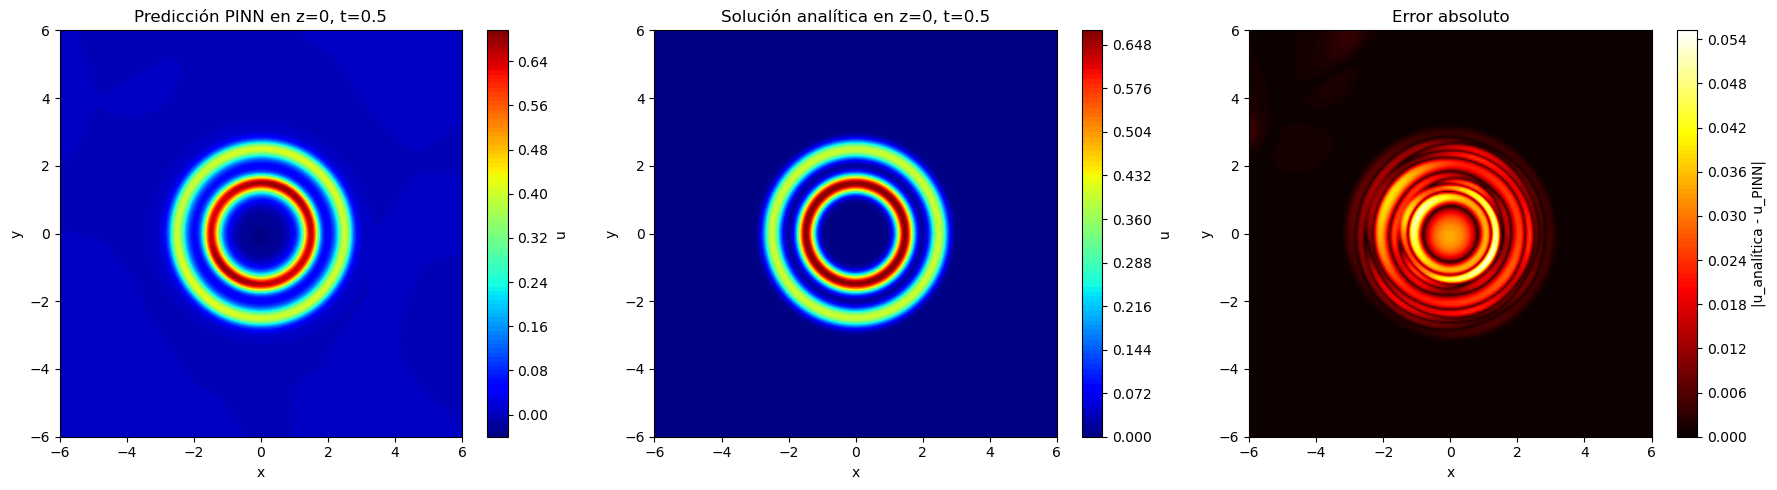

In [24]:
# ===== Graficar con PyPlot sin conflictos =====
using CUDA
using GPUArrays  # para tener AbstractGPUArray

using PyPlot
const plt = PyPlot

# Helper seguro para traer a CPU si estás en GPU
to_host(x) = (CUDA.has_cuda() && x isa AbstractGPUArray) ? Array(x) : x

# -----------------------------
# Malla en el plano z=0, t=0.5
# -----------------------------
nx, ny = 200, 200
x_vals = range(config[:xmin], config[:xmax], length=nx)
y_vals = range(config[:ymin], config[:ymax], length=ny)

# Construimos grillas (Matrices nx×ny)
X_mesh = [x for x in x_vals, y in y_vals]
Y_mesh = [y for x in x_vals, y in y_vals]
Z_mesh = zeros(size(X_mesh))          # z = 0
T_mesh = fill(0.5, size(X_mesh))      # t = 0.5

# Aplanamos a 1×(nx*ny) para evaluar la red
x_flat = reshape(X_mesh, 1, :)
y_flat = reshape(Y_mesh, 1, :)
z_flat = reshape(Z_mesh, 1, :)
t_flat = reshape(T_mesh, 1, :)

# -----------------------------
# Evaluación PINN y analítica
# -----------------------------
u_pinn = calculate_f(x_flat, y_flat, z_flat, t_flat, NN, Θ, st)
u_pinn = to_host(u_pinn)
u_pinn = reshape(u_pinn, size(X_mesh))

u_ref = u_analytic(x_flat, y_flat, z_flat, t_flat,
                   config[:A], config[:sigma], config[:c], config[:r0])
u_ref = to_host(u_ref)
u_ref = reshape(u_ref, size(X_mesh))

error_abs = abs.(u_ref .- u_pinn)

# -----------------------------
# Plot con PyPlot (solo plt.*)
# -----------------------------
plt.figure(figsize=(18,5))

# 1) PINN
plt.subplot(1,3,1)
plt.contourf(X_mesh, Y_mesh, u_pinn, 100, cmap="jet")
plt.colorbar(label="u")
plt.title("Predicción PINN en z=0, t=0.5")
plt.xlabel("x"); plt.ylabel("y")

# 2) Analítica
plt.subplot(1,3,2)
plt.contourf(X_mesh, Y_mesh, u_ref, 100, cmap="jet")
plt.colorbar(label="u")
plt.title("Solución analítica en z=0, t=0.5")
plt.xlabel("x"); plt.ylabel("y")

# 3) Error absoluto
plt.subplot(1,3,3)
plt.contourf(X_mesh, Y_mesh, error_abs, 100, cmap="hot")
plt.colorbar(label="|u_analítica - u_PINN|")
plt.title("Error absoluto")
plt.xlabel("x"); plt.ylabel("y")

plt.tight_layout()
plt.show()

println("Error absoluto medio = ", mean(error_abs))
